In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_excel('/content/owid-energy-data.xlsx')
target = 'electricity_demand'

df = df.dropna(subset=[target])

leaking_cols = [col for col in df.columns if 'electricity' in col or 'generation' in col]
leaking_cols.remove(target)
df = df.drop(columns=leaking_cols)

cols_to_drop = ['country', 'iso_code'] + \
               [c for c in df.columns if '_per_capita' in c or '_share' in c or '_change' in c]
df = df.drop(columns=cols_to_drop, errors='ignore')

missing_pct = df.isnull().mean() * 100
high_missing_cols = missing_pct[missing_pct > 70].index
df = df.drop(columns=high_missing_cols)

df_numeric = df.select_dtypes(include=[np.number])

X = df_numeric.drop(columns=[target])
y = df_numeric[target]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
def evaluate_model(model, name):
    pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"--- {name} ---")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R2   : {r2:.4f}\n")

    return pipeline, y_pred

lr_pipeline, y_pred_lr = evaluate_model(LinearRegression(), "Baseline(Linear Regression")
rf_pipeline, y_pred_rf = evaluate_model(RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42), "Model(Random Forest)")

--- Baseline: Linear Regression ---
RMSE : 279.8989
MAE  : 90.9863
R2   : 0.9872

--- Model: Random Forest ---
RMSE : 101.9277
MAE  : 21.4598
R2   : 0.9983



In [12]:
##Stress test

HASIL STRESS TEST PADA RANDOM FOREST


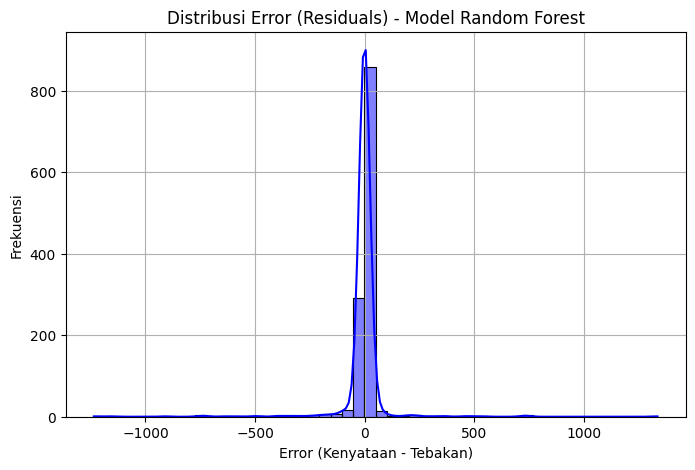


--- Evaluasi Outlier (Data Kebutuhan Listrik Ekstrem) ---
Jumlah data normal      : 1014 baris
Jumlah data outlier     : 216 baris
MAE pada data Normal    : 3.0162
MAE pada data Outlier   : 108.0421

--- Evaluasi Injeksi Noise (Ketahanan Model) ---
R2 Asli (Tanpa Noise)           : 0.9983
R2 Setelah di-Stress (Ada Noise): 0.9927
Penurunan R2                    : 0.0056


In [13]:
print("="*40)
print("HASIL STRESS TEST PADA RANDOM FOREST")
print("="*40)

residuals = y_test - y_pred_rf
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=50, color='blue')
plt.title('Distribusi Error (Residuals) - Model Random Forest')
plt.xlabel('Error (Kenyataan - Tebakan)')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

Q3 = np.percentile(y_test, 75)
IQR = np.percentile(y_test, 75) - np.percentile(y_test, 25)
upper_bound = Q3 + 1.5 * IQR

outlier_mask = y_test > upper_bound

if outlier_mask.sum() > 0:
    mae_normal = mean_absolute_error(y_test[~outlier_mask], y_pred_rf[~outlier_mask])
    mae_outlier = mean_absolute_error(y_test[outlier_mask], y_pred_rf[outlier_mask])

    print("\n--- Evaluasi Outlier (Data Kebutuhan Listrik Ekstrem) ---")
    print(f"Jumlah data normal      : {sum(~outlier_mask)} baris")
    print(f"Jumlah data outlier     : {sum(outlier_mask)} baris")
    print(f"MAE pada data Normal    : {mae_normal:.4f}")
    print(f"MAE pada data Outlier   : {mae_outlier:.4f}")

noise_factor = 0.1
X_test_noisy = X_test.copy()

for col in X_test.columns:
    std_val = X_test[col].std()
    if std_val > 0 and not pd.isna(std_val):
        noise = np.random.randn(len(X_test)) * std_val * noise_factor
        X_test_noisy[col] = X_test_noisy[col] + noise

y_pred_noisy = rf_pipeline.predict(X_test_noisy)

r2_original = r2_score(y_test, y_pred_rf)
r2_noisy = r2_score(y_test, y_pred_noisy)

print("\n--- Evaluasi Injeksi Noise (Ketahanan Model) ---")
print(f"R2 Asli (Tanpa Noise)           : {r2_original:.4f}")
print(f"R2 Setelah di-Stress (Ada Noise): {r2_noisy:.4f}")
print(f"Penurunan R2                    : {(r2_original - r2_noisy):.4f}")